# Chapter 6: Explainable Boosting Machines and Explaining XGBoost for Consumer Finance

## The GAM Family of Interpretable Models



## Contents  

1. [Importing & Preparing data](#importing-and-preparing-Data)
2. [Elastic Net Penalized GLM w/ Alpha and Lambda Search](#elastic-net)
    - Finding the best GLM model using Grid Search
    - Displaying the best GLM information
    - Computing Validation AUC
    - Plotting the partial dependence and ICE plots for selected features in best GLM
3. [Generalized Additive Model](#gam)
    - Train Logistic GAM with pyGAM package
    - Display tuned GAM information
    - Computing Validation AUC
    - Examining Partial Dependence and ICE plots for best GAM 
4. [GA2M and Explainable Boosting Machines](#ebm)
    - Train EBM with interpretml package
    - Computing Validation AUC
    - Examining Partial Dependence and ICE plots for EBM
     

## Resources

### GA2M and EBM

1. [InterpretML: A toolkit  for understanding machine  learning  models](https://www.microsoft.com/en-us/research/uploads/prod/2020/05/InterpretML-Whitepaper.pdf)




## <a name="importing-and-preparing-Data"></a>1.Importing and preparing Data



In [1]:
SEED                    = 12345  
GLM_SELECTION_THRESHOLD = 0.001  #Setting a threshold for GLM feature selection

In [38]:
# Data manipulation, plotting and metrics
import numpy as np
import pandas as pd   
import operator                                                   
import matplotlib.pyplot as plt 
from sklearn import metrics

# For plotting partial dependence plots
from hrml_book import explain


# h2o python bindings to java server
import h2o  
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
np.random.seed(SEED)
h2o.init(max_mem_size='8G', nthreads=4) 
h2o.remove_all()                         
h2o.no_progress()  


# PyGAM
from pygam import LogisticGAM

# EBM
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.blackbox import PartialDependence
from interpret import show


# Disable warnings
import warnings                         
warnings.filterwarnings("ignore",category=UserWarning)
pd.set_option('mode.chained_assignment',None)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,32 mins 12 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,2 months and 5 days
H2O_cluster_name:,H2O_from_python_parulpandey_1csu43
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,15.62 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [3]:
data = pd.read_csv('Data/credit_line_increase.csv')
data.head()

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
0,1,20000,2,1.0,2,1,24,2,2,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2.0,2,2,26,-1,2,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,3.0,2,2,34,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,4.0,2,1,37,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,3.0,2,1,57,-1,0,-1,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### Split data into training and validation sets
Split the data in the training and validation set using a 70:30 ratio. 

In [4]:
split_ratio = 0.7 # 70%/30% train/test split

split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

print(f'Shape of Train data : {train.shape}')
print(f'Shape of Validation data : {valid.shape}')

Shape of Train data : (20946, 26)
Shape of Validation data : (9054, 26)


#### Assign target and inputs for models

Note that **Demographic** features are not used as model inputs.

In [5]:
target = 'DELINQ_NEXT'
demographic_cols = ['SEX', 'RACE','EDUCATION', 'MARRIAGE', 'AGE']
features = [col for col in data.columns if col not in demographic_cols + ['ID',target]]

print('target =', target)
print('predictors =', features)

target = DELINQ_NEXT
predictors = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


## <a name="elastic-net"></a>2. Elastic Net Penalized GLM with Alpha and Lambda Search



### Finding the best GLM model using Grid Search



In [6]:
def glm_grid(x, y, training_frame, validation_frame, seed_, weight=None):
    """
    :param x: List of inputs.
    :param y: Name of target variable.
    :param training_frame: Training H2OFrame.
    :param validation_frame: Validation H2OFrame.
    :param seed_: Random seed for better reproducibility.
    :return: Best H2OGeneralizedLinearEstimator.
    """

    #Settings GLM grid parameters
    alpha_opts = [0.01, 0.25, 0.5, 0.99]  
    hyper_parameters = {'alpha': alpha_opts}

    # initialize cartesian grid search
    glm_grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family="binomial",
                                      lambda_search=True,
                                      seed=seed_),
                                      hyper_params=hyper_parameters)

    # training w/ grid search
    glm_grid.train(y=y,
               x=x,
               training_frame=training_frame,
               validation_frame=validation_frame,
               weights_column=weight,
               seed=seed_)

    # select best model from grid search
    best_model = glm_grid.get_grid()[0]
    del glm_grid

    return best_model

#### Print selected coefficients

In [7]:
best_glm = glm_grid(x=features, y=target, training_frame=h2o.H2OFrame(train),
                         validation_frame= h2o.H2OFrame(valid), seed_=SEED)

# print selected GLM coefficients
print('Best penalized GLM coefficients:')
for c_name, c_val in sorted(best_glm.coef().items(), key=operator.itemgetter(1)):
    if abs(c_val) > GLM_SELECTION_THRESHOLD:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))

Best penalized GLM coefficients:
Intercept:                -1.0553055885519231
PAY_6:                    0.01228251528190359
PAY_4:                    0.02548663430338334
PAY_5:                    0.046139370544830756
PAY_3:                    0.07909158701433712
PAY_2:                    0.08471364623597921
PAY_0:                    0.5371954715199957


### Display best GLM information

In [8]:
best_glm 

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_ac4d09fbab4899e89c580b16d921413f.hex_model_python_1639323916068_19_model_1


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.01, lambda = 0.005908 )","nlambda = 100, lambda.max = 13.333, lambda.min = 0.005908, lambda....",19,19,109,Key_Frame__upload_ac4d09fbab4899e89c580b16d921413f.hex




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.146491589159547
RMSE: 0.38274219673240495
LogLoss: 0.4685812636002606
Null degrees of freedom: 20945
Residual degrees of freedom: 20926
Null deviance: 22178.75361964548
Residual deviance: 19629.806294742117
AIC: 19669.806294742117
AUC: 0.7182752479663853
AUCPR: 0.5017943091688167
Gini: 0.4365504959327706

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24983106738243763: 


,,0,1,Error,Rate
0,0,13778.0,2518.0,0.1545,(2518.0/16296.0)
1,1,2168.0,2482.0,0.4662,(2168.0/4650.0)
2,Total,15946.0,5000.0,0.2237,(4686.0/20946.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.249831,0.514404,205.0
1,max f2,0.054654,0.594059,377.0
2,max f0point5,0.399178,0.567555,137.0
3,max accuracy,0.418922,0.817053,128.0
4,max precision,0.706802,0.797414,34.0
5,max recall,0.001281,1.000000,399.0
6,max specificity,0.989212,0.999570,0.0
7,max absolute_mcc,0.399178,0.396395,137.0
8,max min_per_class_accuracy,0.221641,0.658925,237.0
9,max mean_per_class_accuracy,0.245211,0.690483,210.0



Gains/Lift Table: Avg response rate: 22.20 %, avg score: 22.20 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010026,7.192943e-01,3.539263,3.539263,0.785714,0.816889,0.785714,0.816889,0.035484,0.035484,253.926267,253.926267,0.032722
1,2,0.020004,6.109553e-01,2.952721,3.246692,0.655502,0.659815,0.720764,0.738540,0.029462,0.064946,195.272110,224.669182,0.057767
2,3,0.030030,5.904669e-01,3.303312,3.265595,0.733333,0.600522,0.724960,0.692461,0.033118,0.098065,230.331183,226.559516,0.087448
3,4,0.040008,5.652261e-01,3.469986,3.316571,0.770335,0.576997,0.736277,0.663664,0.034624,0.132688,246.998611,231.657094,0.119127
4,5,0.050033,5.378222e-01,3.024461,3.258037,0.671429,0.552092,0.723282,0.641307,0.030323,0.163011,202.446083,225.803743,0.145215
5,6,0.100019,4.442181e-01,2.916965,3.087582,0.647564,0.484561,0.685442,0.562971,0.145806,0.308817,191.696460,208.758242,0.268378
6,7,0.150005,3.537487e-01,2.090922,2.755468,0.464183,0.405265,0.611712,0.510419,0.104516,0.413333,109.092153,175.546785,0.338468
7,8,0.200038,2.655100e-01,1.427003,2.423193,0.316794,0.294731,0.537947,0.456471,0.071398,0.484731,42.700320,142.319316,0.365929
8,9,0.300010,2.382281e-01,1.015345,1.954060,0.225406,0.248630,0.433800,0.387213,0.101505,0.586237,1.534461,95.405967,0.367901
9,10,0.400029,2.224902e-01,0.672990,1.633754,0.149403,0.229921,0.362692,0.347885,0.067312,0.653548,-32.701024,63.375397,0.325861




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.14363466020798754
RMSE: 0.3789916360660055
LogLoss: 0.4617337838828071
Null degrees of freedom: 9053
Residual degrees of freedom: 9034
Null deviance: 9526.71172610569
Residual deviance: 8361.075358549871
AIC: 8401.075358549871
AUC: 0.7303402396287311
AUCPR: 0.506856209860291
Gini: 0.46068047925746214

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2607285198255575: 


,,0,1,Error,Rate
0,0,6083.0,985.0,0.1394,(985.0/7068.0)
1,1,921.0,1065.0,0.4637,(921.0/1986.0)
2,Total,7004.0,2050.0,0.2105,(1906.0/9054.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.260729,0.527750,193.0
1,max f2,0.116430,0.592436,329.0
2,max f0point5,0.400670,0.576923,134.0
3,max accuracy,0.433434,0.822288,120.0
4,max precision,0.572358,0.743386,68.0
5,max recall,0.007410,1.000000,397.0
6,max specificity,0.989045,0.999859,0.0
7,max absolute_mcc,0.370892,0.413902,147.0
8,max min_per_class_accuracy,0.225699,0.672205,230.0
9,max mean_per_class_accuracy,0.246401,0.699498,206.0



Gains/Lift Table: Avg response rate: 21.94 %, avg score: 22.66 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010051,7.207631e-01,3.106072,3.106072,0.681319,0.813734,0.681319,0.813734,0.031219,0.031219,210.607218,210.607218,0.027116
1,2,0.020102,6.229843e-01,3.156170,3.131121,0.692308,0.663736,0.686813,0.738735,0.031722,0.062941,215.617011,213.112114,0.054876
2,3,0.030042,5.993452e-01,3.545821,3.268338,0.777778,0.607299,0.716912,0.695245,0.035247,0.098187,254.582075,226.833792,0.087293
3,4,0.040093,5.753741e-01,3.757345,3.390927,0.824176,0.587697,0.743802,0.668284,0.037764,0.135952,275.734537,239.092657,0.122794
4,5,0.050033,5.509826e-01,3.241893,3.361317,0.711111,0.562950,0.737307,0.647357,0.032226,0.168177,224.189325,236.131730,0.151341
5,6,0.100066,4.545088e-01,2.968828,3.165073,0.651214,0.496126,0.694260,0.571741,0.148540,0.316717,196.882815,216.507273,0.277526
6,7,0.149989,3.741888e-01,2.208854,2.846802,0.484513,0.414835,0.624448,0.519516,0.110272,0.426989,120.885357,184.680243,0.354833
7,8,0.200022,2.740947e-01,1.489446,2.507276,0.326711,0.315894,0.549972,0.468582,0.074522,0.501511,48.944599,150.727595,0.386202
8,9,0.299978,2.407348e-01,0.997420,2.004176,0.218785,0.253042,0.439617,0.396762,0.099698,0.601208,-0.258049,100.417577,0.385872
9,10,0.400044,2.249573e-01,0.719563,1.682845,0.157837,0.232429,0.369133,0.355656,0.072004,0.673212,-28.043657,68.284535,0.349924




Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,alpha,iterations,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-12-12 21:22:00,0.000 sec,1,.13E2,1,1.058854,1.052210,0.01,NaN,...,,,,,,,,,,
1,,2021-12-12 21:22:00,0.005 sec,2,.12E2,2,1.058595,1.051942,0.01,NaN,...,,,,,,,,,,
2,,2021-12-12 21:22:00,0.010 sec,3,.11E2,2,1.058312,1.051649,0.01,NaN,...,,,,,,,,,,
3,,2021-12-12 21:22:00,0.014 sec,4,.1E2,3,1.057846,1.051165,0.01,NaN,...,,,,,,,,,,
4,,2021-12-12 21:22:00,0.020 sec,5,.92E1,4,1.057200,1.050494,0.01,NaN,...,,,,,,,,,,
5,,2021-12-12 21:22:00,0.026 sec,6,.84E1,5,1.056328,1.049589,0.01,NaN,...,,,,,,,,,,
6,,2021-12-12 21:22:00,0.031 sec,7,.76E1,6,1.055193,1.048412,0.01,NaN,...,,,,,,,,,,
7,,2021-12-12 21:22:00,0.036 sec,8,.7E1,7,1.053849,1.047023,0.01,NaN,...,,,,,,,,,,
8,,2021-12-12 21:22:00,0.041 sec,9,.63E1,7,1.052407,1.045532,0.01,NaN,...,,,,,,,,,,
9,,2021-12-12 21:22:00,0.045 sec,10,.58E1,8,1.050810,1.043879,0.01,NaN,...,,,,,,,,,,



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,PAY_0,0.603654,1.000000,0.342944
1,PAY_AMT1,0.204687,0.339080,0.116286
2,PAY_AMT2,0.178758,0.296126,0.101555
3,BILL_AMT1,0.164762,0.272941,0.093604
4,PAY_2,0.100917,0.167177,0.057332
5,PAY_3,0.094259,0.156148,0.053550
6,LIMIT_BAL,0.056065,0.092876,0.031851
7,PAY_AMT4,0.054057,0.089550,0.030711
8,BILL_AMT5,0.052395,0.086797,0.029766
9,PAY_5,0.051936,0.086037,0.029506


#### Plotting penalized GLM variable importance

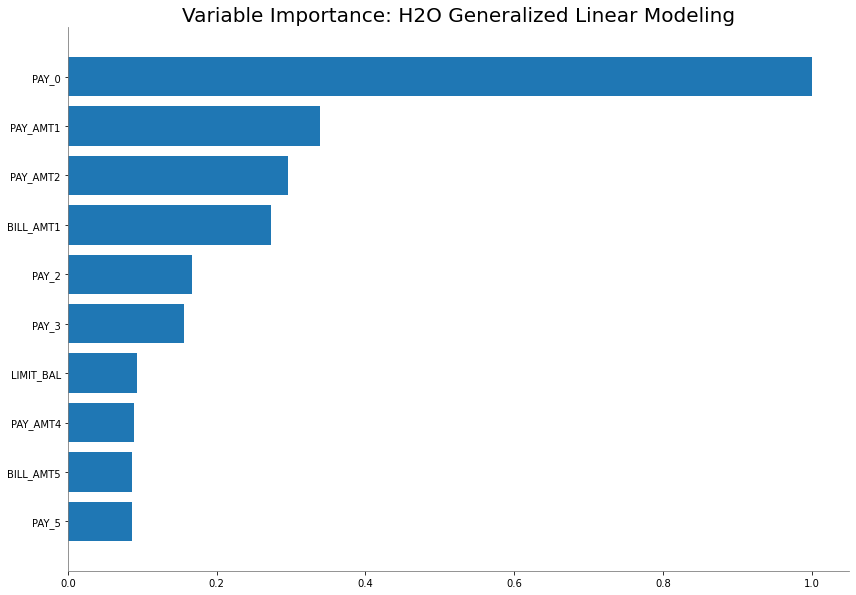

In [9]:
best_glm.varimp_plot()

### Computing Validation AUC

In [10]:
print("Validation AUC: {0:.5f}".format(best_glm.auc(valid = True)))

Validation AUC: 0.73034


### Partial Dependence and ICE for Model Documentation

#### Performing feature selection in best GLM

In [11]:
# collect regularization paths from dict in DataFrame
reg_path_dict = best_glm.getGLMRegularizationPath(best_glm)
reg_path_frame = pd.DataFrame(columns=reg_path_dict['coefficients'][0].keys())
for i in range(0, len(reg_path_dict['coefficients'])): 
    reg_path_frame = reg_path_frame.append(reg_path_dict['coefficients'][i], 
                                           ignore_index=True)
    

    
# establish benchmark feature selection: glm_selected       
glm_selected = list(reg_path_frame.iloc[-1, :][reg_path_frame.iloc[-1, :] > GLM_SELECTION_THRESHOLD].index)

#### Plotting the partial dependence and ICE plots for selected features in best GLM

In [12]:
glm_predict = lambda data: best_glm.predict(h2o.H2OFrame(data))['p1'].as_data_frame()

pd_ice_dict = {}

# calculate partial dependence for each selected feature
for feat in features: 
    pd_ice_dict[feat] = explain.pd_ice_new(feat, valid, glm_predict)

In [13]:
def get_percentile_dict(yhat_name, valid, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
    :param yhat_name: Name of column in valid in which to find percentiles.
    :param valid: Pandas validation frame.
    :param id_: Validation Pandas frame containing yhat and id_.
    :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = valid.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict


In [14]:
glm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                            best_glm.predict(h2o.H2OFrame(valid))['p1'].as_data_frame()],
                           axis=1)

# rename yhat column
glm_yhat_valid = glm_yhat_valid.rename(columns={'p1':'p_DELINQ_NEXT'})

# find percentiles of predictions
percentile_dict = get_percentile_dict('p_DELINQ_NEXT', glm_yhat_valid, 'ID')

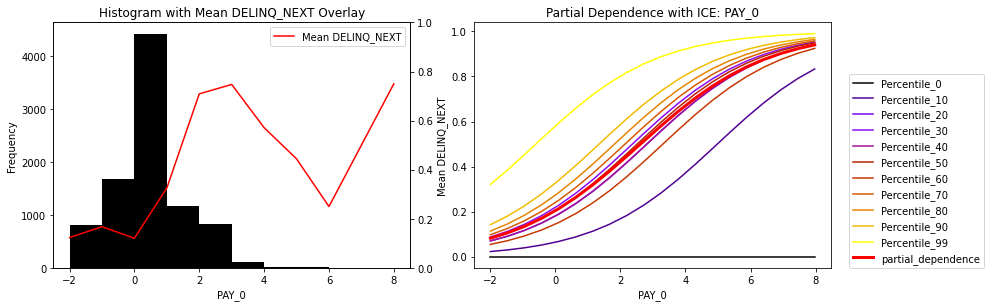

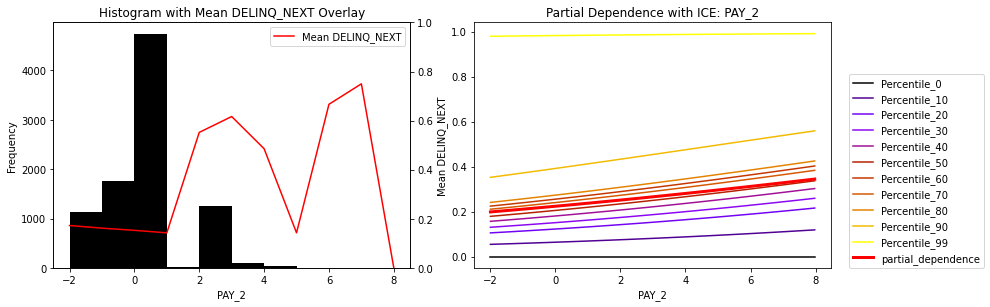

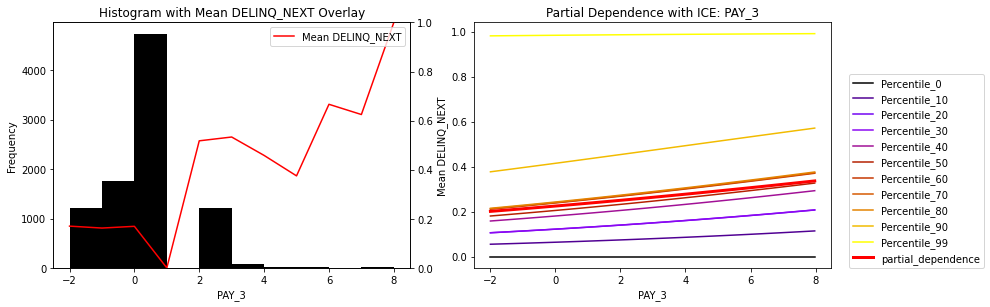

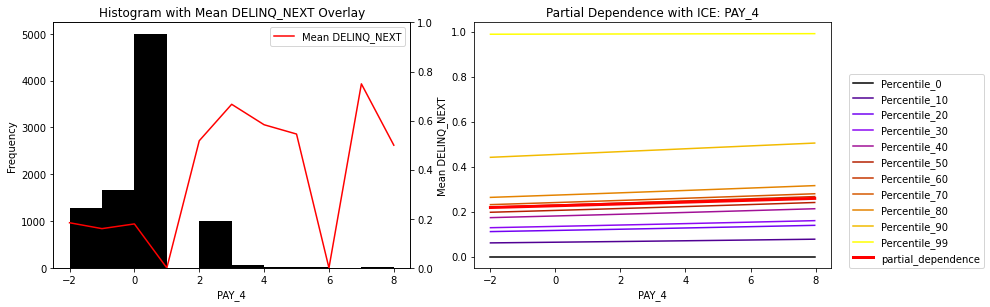

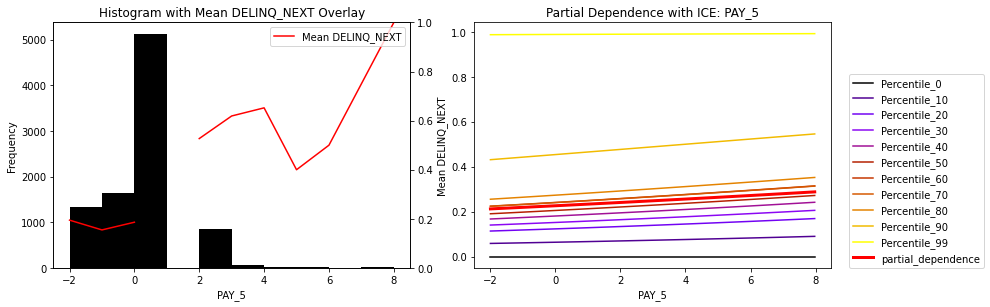

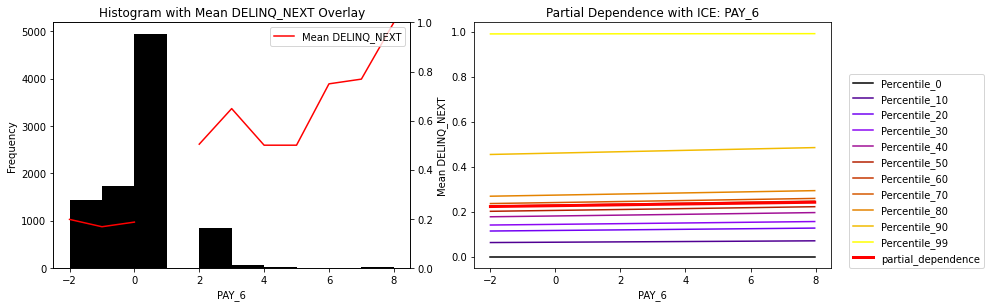

In [15]:
# loop through selected variables
for feat in glm_selected: 

    # collect bins used in partial dependence
    bins = list(pd_ice_dict[feat][feat])
    
    # calculate ICE at percentiles using partial dependence bins for each feature
    for i in sorted(percentile_dict.keys()):
        col_name = 'Percentile_' + str(i)
        pd_ice_dict[feat][col_name] = explain.pd_ice_new(feat,
                                                 valid[valid['ID'] == int(percentile_dict[i])], 
                                                 glm_predict, 
                                                 bins=bins)['partial_dependence']


for feature in glm_selected:
    explain.hist_mean_pd_ice_plot(feature,
                                 target,
                                 valid,
                                 pd_ice_dict)

---

## <a name="gam"></a>3. Generalized Additive Models(GAM)

### Train Logistic GAM with pyGAM package



In this section we'll  implement a `LogisticGAM` using the [pyGAM](https://github.com/dswah/pyGAM) package in Python. pyGAM's `LogisticGAM` class is used for classification tasks.

In [16]:
from pygam import LogisticGAM

gam = LogisticGAM(max_iter=100, n_splines=30)
 

#### Finding the best LogisticGAM model using Grid Search

In [17]:
gam.gridsearch(train[features].values, train[target], lam=np.logspace(-3, 3, 15))

  0% (0 of 15) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/parulpandey/anaconda3/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: overflow encountered in square
  self.distribution.V(mu=mu) *
  6% (1 of 15) |#                        | Elapsed Time: 0:00:13 ETA:   0:03:03/Users/parulpandey/anaconda3/lib/python3.7/site-packages/pygam/pygam.py:592: RuntimeWarning: overflow encountered in square
  self.distribution.V(mu=mu) *
100% (15 of 15) |########################| Elapsed Time: 0:02:59 Time:  0:02:59


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + intercept,
   tol=0.0001, verbose=False)

### Display tuned GAM information


In [18]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     83.7605
Link Function:                        LogitLink Log Likelihood:                                 -9074.1214
Number of Samples:                        20946 AIC:                                            18315.7639
                                                AICc:                                           18316.4608
                                                UBRE:                                               2.8776
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1817
Feature Function                  Lam

### Computing Validation AUC

In [19]:
predictions = gam.predict_proba(valid[features])
validation_auc = metrics.roc_auc_score(valid[target], predictions)
print("Validation AUC: {0:.5f}".format(validation_auc))

Validation AUC: 0.77989


### Examining Partial Dependence and ICE plots for best GAM 

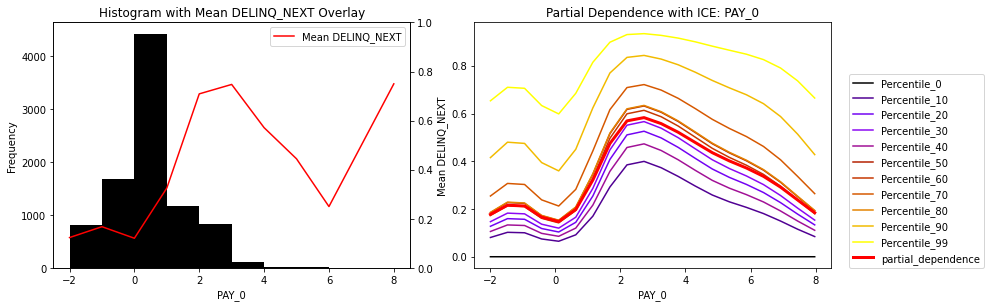

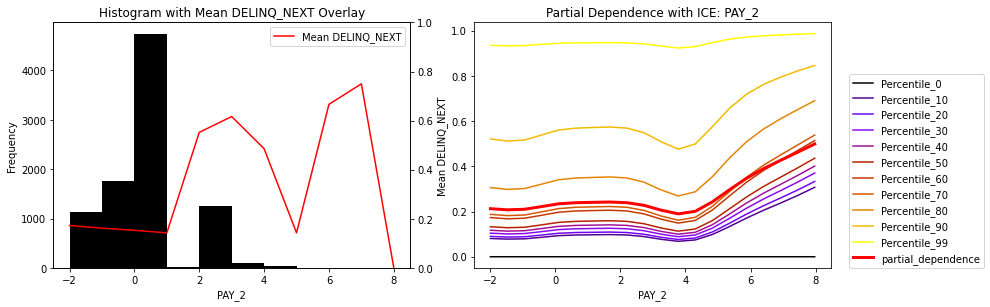

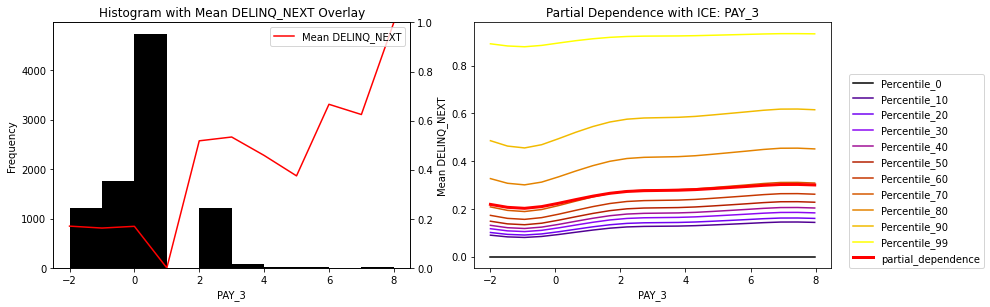

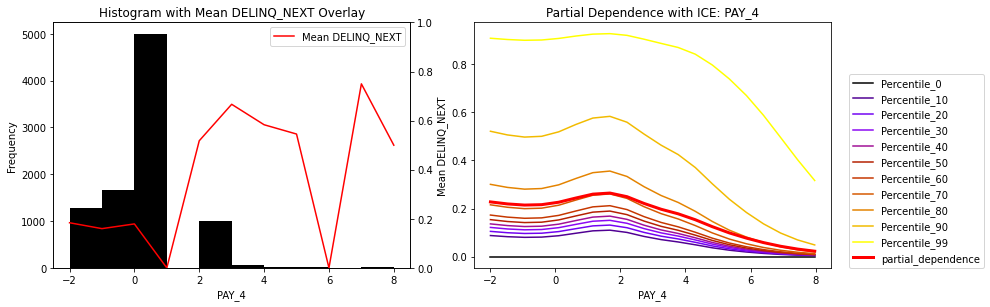

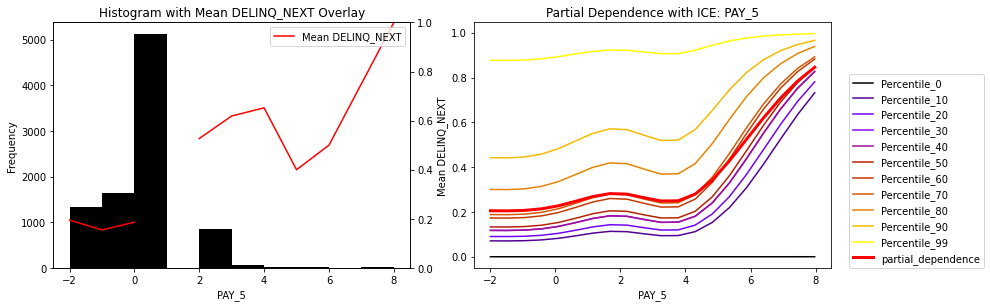

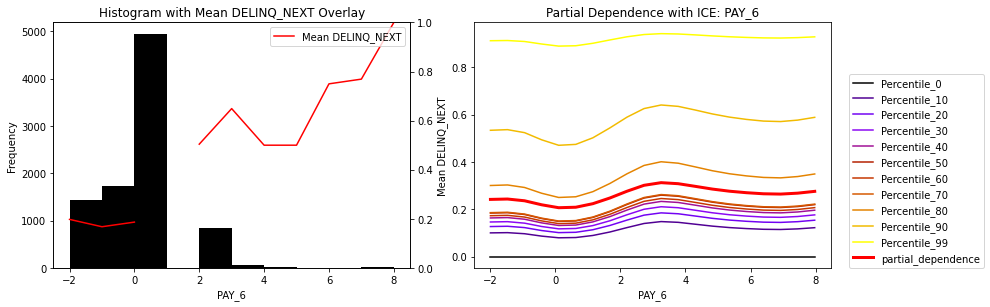

In [20]:
gam_predict = lambda data: gam.predict_proba(data[features])

for feature in glm_selected:
    explain.plot_partial_dep_ice(feature,
                                 X=valid[features],
                                 y=valid[target],
                                 predict=gam_predict)



## <a name="ebm"></a>4. GA2Ms & Explainable Boosting Machine(EBMs) 



### Train EBM with interpretml package

In [51]:
ebm = ExplainableBoostingClassifier(random_state=SEED, n_jobs=-1)
ebm.fit(train[features], train[target])


ExplainableBoostingClassifier(feature_names=['LIMIT_BAL', 'PAY_0', 'PAY_2',
                                             'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                                             'BILL_AMT1', 'BILL_AMT2',
                                             'BILL_AMT3', 'BILL_AMT4',
                                             'BILL_AMT5', 'BILL_AMT6',
                                             'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                                             'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                                             'PAY_0 x PAY_2', 'PAY_0 x PAY_3',
                                             'PAY_0 x BILL_AMT1',
                                             'PAY_0 x PAY_4',
                                             'PAY_0 x PAY_AMT2',
                                             'PAY_0 x PAY_AMT3',
                                             'LIMIT_BAL x BI...
                                             'continuous', 'continu

#### Variable Importance

<AxesSubplot:ylabel='feature_names'>

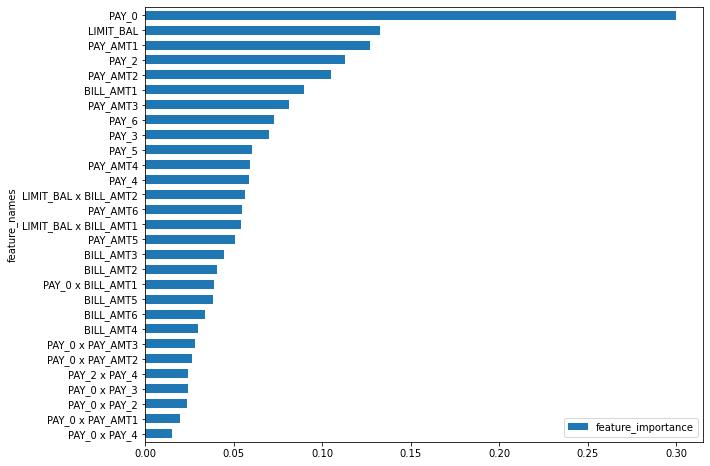

In [52]:
ebm_global = ebm.explain_global(name='EBM')
feature_names = ebm_global._internal_obj['overall']['names']
feature_importances = ebm_global._internal_obj['overall']['scores']

ebm_variable_importance = pd.DataFrame(zip(feature_names, feature_importances), 
                                       columns=['feature_names','feature_importance'])

ebm_variable_importance.set_index('feature_names',inplace=True)
ebm_variable_importance.sort_values(by='feature_importance').plot(kind='barh',
                                                                       width = 0.6, 
                                                                       figsize=(10,8))

#### Display interactive EBM feature plots 

The live visualization shows the overall summary depicting the most important features overall. Additinally you can use the dropdown to further drill down into individual features.

In [53]:
show(ebm_global)

### Computing Validation AUC

In [54]:
from interpret.perf import ROC

ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[features], valid[target], name='EBM')
ebm_perf._internal_obj['overall']['auc']

0.7853183233397791

### Examining Partial Dependence and ICE plots for EBM

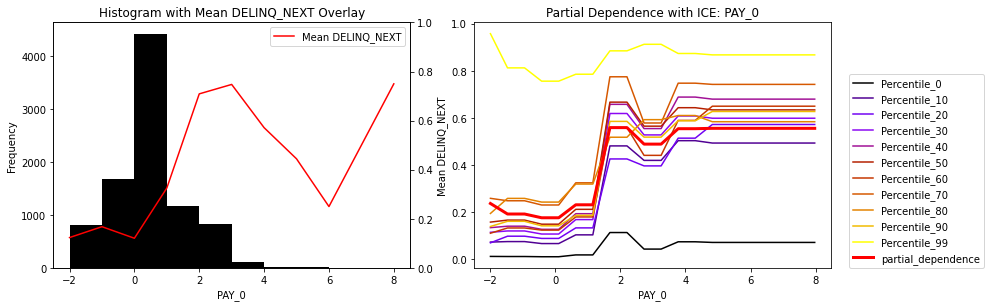

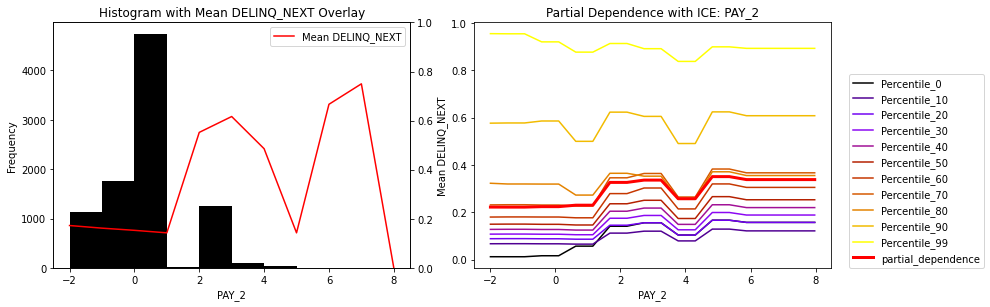

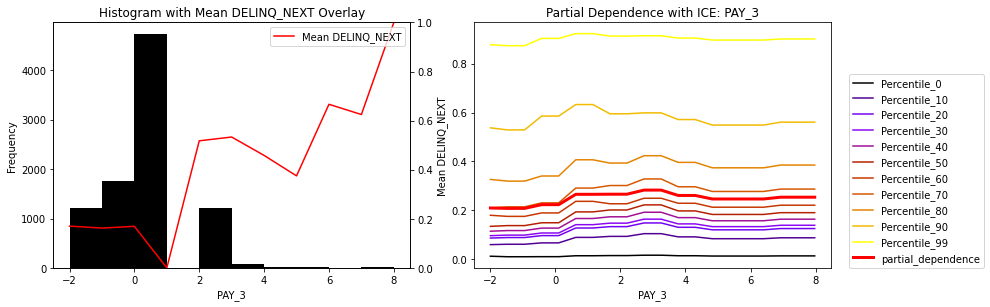

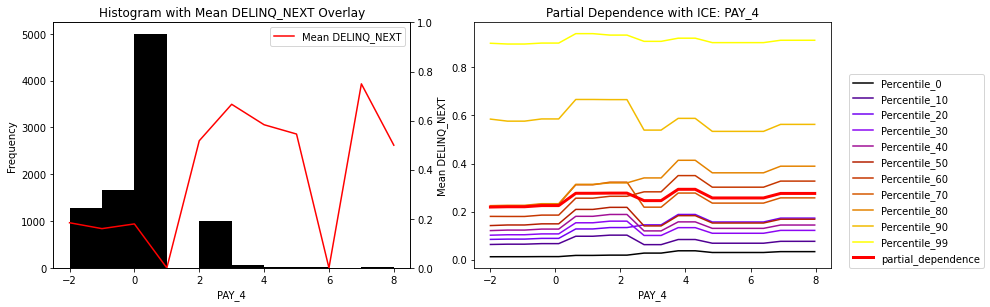

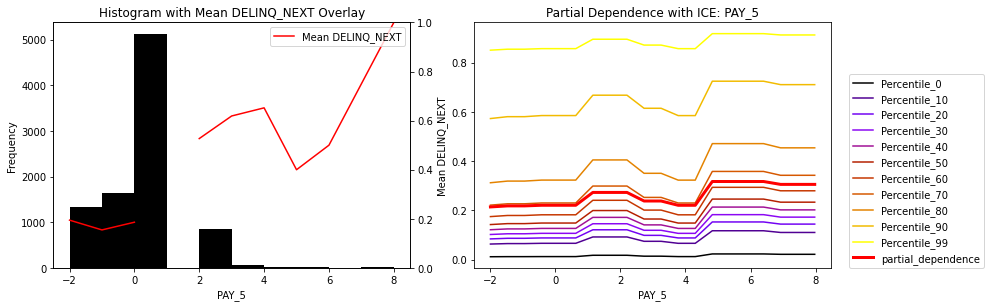

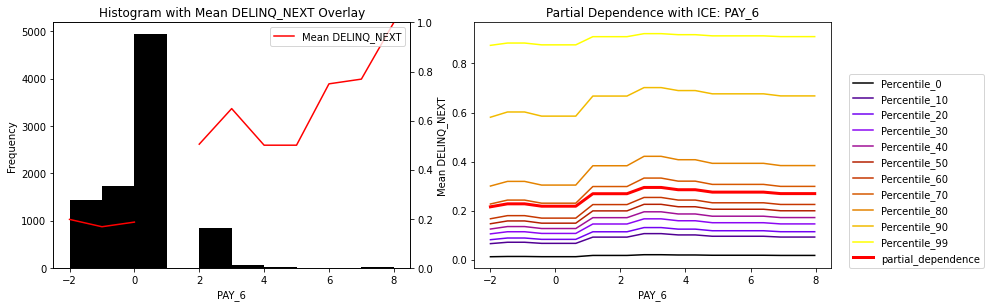

In [55]:
ebm_predict = lambda data: ebm.predict_proba(data[features])[:, 1]

for feature in glm_selected:
    explain.plot_partial_dep_ice(feature,
                                 X=valid[features],
                                 y=valid[target],
                                 predict=ebm_predict)

#### Shutdown H2O Cluster

In [56]:

#h2o.cluster().shutdown(prompt=True)